In [969]:
### Imports ###
import os
import numpy as np 
import pandas as pd 
import matplotlib

In [970]:
NAMES = ["qs", "depth", "tcount", "red_tcount","min_weight","max_weight","seed","terms","time","alpha"]
# NAMES = ["qs", "depth", "tcount", "min_weight", 
#                "max_weight", "nsamples", "seed", "terms", 
#                "time", "tcounts", "no_simp", "naive", "alpha"]
groupby_data = "red_tcount"
TIMEOUT = 40 * 1000

In [971]:
### Collect Simulation Data ###
dfs = []
data_folder = "data_cat3_single_full_0719"
feat_name = "min_uncut"
for f in os.listdir(data_folder):
    # if "100_70_2_4_1_4842" in f: continue
    curr = pd.read_csv(
        f"{data_folder}/{f}", 
        header=None, 
        names=NAMES
    )    
    curr.loc[0, feat_name] = True
    dfs.append(curr)
    

og_data_folder = "data_og_full_0711"
for f in os.listdir(og_data_folder):
    curr = pd.read_csv(
        f"{og_data_folder}/{f}", 
        header=None, 
        names=NAMES
    )
    curr.loc[0, feat_name] = False
    dfs.append(curr)

full_data = pd.concat(dfs, ignore_index=True)



# full_data["max_tcount"] = full_data["tcounts"].str.split(",")
# if full_data["alpha"].dtype != np.float64:
#     full_data["alpha"] = full_data["alpha"].str.split(",")
#     # full_data = full_data.explode(["max_tcount", "alpha"])
#     # print(len(full_data["alpha"][100]))
#     full_data["alpha"] = full_data["alpha"].apply(lambda x: x[int(len(x)*0.9)])
#     full_data["max_tcount"] = full_data["max_tcount"].apply(lambda x: x[int(len(x)*0.9)])

#     # full_data["argmax"] = full_data["alpha"].apply(lambda x: np.argmax([float(i) for i in x]))
#     # full_data["alpha"] = full_data.apply(lambda x: x["alpha"][x["argmax"]], axis=1)
#     # full_data["max_tcount"] = full_data.apply(lambda x: x["max_tcount"][x["argmax"]], axis=1)
# else:
#     full_data = full_data.explode("max_tcount")

# full_data = full_data.astype({"max_tcount": int, "alpha": float})

# # full_data["max_tcount"] = full_data["max_tcount"].apply(lambda x: max(x, 1))
# full_data = full_data[full_data["max_tcount"] > 0]


def parse_tcounts_max(tcounts):
    return max(max(map(int, tcounts.split(","))), 1)

def parse_alphas_tcounts(alphas, tcounts):
    if "," not in alphas:
        return float(alphas), parse_tcounts_max(tcounts)
    alpha_t = list(zip([int(x) for x in alphas.split(",")], [int(x) for x in tcounts.split(",")]))
    return max(alpha_t, key=lambda x: x[0])




full_data = full_data[full_data['alpha'] >= 0]
full_data = full_data[full_data['time'] <= 1 * TIMEOUT]
# Apply the function to the column and create a new column
# full_data['max_tcount'] = full_data['tcounts'].apply(parse_tcounts_max)
# print(full_data["sum_tcounts"].dtype)
# full_data["alpha"] = np.log2(full_data["terms"]) / full_data['tcount']
full_data["log_terms"] = np.log10(full_data["terms"])
full_data["log_time"] = np.log10(full_data["time"])
full_data["log_terms"] = full_data["log_terms"].clip(lower=0)
full_data["log_time"] = full_data["log_time"].clip(lower=0)

full_data = full_data[full_data["red_tcount"] > 17]
full_data = full_data[full_data["tcount"] < 110]

# data = full_data.loc[:, ["qs", "tcount","seed","terms", "log_terms", feat_name, "time", "log_time", "alpha", "max_tcount"]]
data = full_data.drop(["min_weight", "max_weight"], axis=1)
data["time"] /= 1000    # convert milliseconds -> seconds
data.head()

/Users/wira/miniconda3/envs/quantum/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,qs,depth,tcount,red_tcount,seed,terms,time,alpha,min_uncut,log_terms,log_time
0,19,30,30,28,1077,678,0.020,0.335898,True,2.831230,1.301030
1,97,90,90,26,7945,16,0.004,0.153846,True,1.204120,0.602060
2,19,30,30,23,7945,262,0.006,0.349279,True,2.418301,0.778151
4,7,30,30,28,1582,2484,0.055,0.402802,True,3.395152,1.740363
5,97,90,90,38,1077,9882,0.566,0.349226,True,3.994845,2.752816


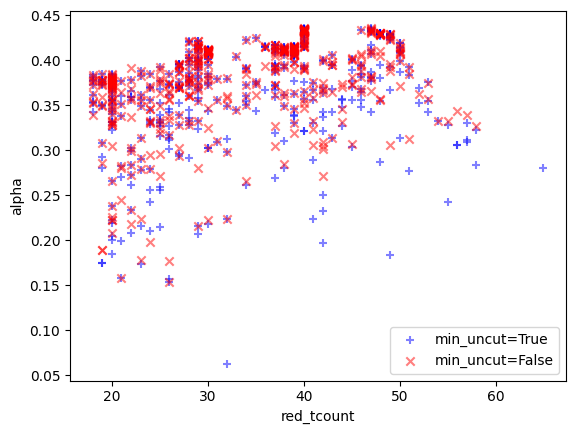

In [972]:
import matplotlib.pyplot as plt

# Filter the data for bcc=True and bcc=False
data_bcc_true = data[data[feat_name] == True]
data_bcc_false = data[data[feat_name] == False]

# Plot the data with translucent points
plt.scatter(data_bcc_true[groupby_data], data_bcc_true['alpha'], color='blue', label=f'{feat_name}=True', alpha=0.5, marker='+')
plt.scatter(data_bcc_false[groupby_data], data_bcc_false['alpha'], color='red', label=f'{feat_name}=False', alpha=0.5, marker='x')

# Set the x-axis label and y-axis label
plt.xlabel(groupby_data)
plt.ylabel('alpha')

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [973]:
### Comparison at each size ###
# groupby_data = "max_tcount"
# feat_name = "min_uncut"
data.groupby([groupby_data,feat_name]).agg(
    avg_time=pd.NamedAgg("time", "mean"),
    std_time=pd.NamedAgg("time", np.std),
    med_time=pd.NamedAgg("time", "median"),
    avg_a=pd.NamedAgg("alpha", "mean"),
    std_a=pd.NamedAgg("alpha", np.std),
    med_a=pd.NamedAgg("alpha", "median"),
)

/var/folders/jj/chbmjhbd5gbd4f05m1x14ld80000gn/T/ipykernel_3463/1834889147.py:4: FutureWarning: The provided callable <function std at 0x10b20cfe0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  data.groupby([groupby_data,feat_name]).agg(


avg_time   std_time  med_time     avg_a     std_a  \
red_tcount min_uncut                                                       
18         False       0.002444   0.001424    0.0020  0.366731  0.015571   
           True        0.001556   0.000726    0.0010  0.367012  0.014883   
19         False       0.002714   0.001069    0.0025  0.333858  0.067822   
           True        0.002429   0.000852    0.0020  0.326531  0.072803   
20         False       0.003304   0.002210    0.0030  0.346033  0.049191   
...                         ...        ...       ...       ...       ...   
57         False      35.774000        NaN   35.7740  0.339216       NaN   
           True       16.328667   8.285068   13.2710  0.317079  0.011865   
58         False      29.421000        NaN   29.4210  0.326853       NaN   
           True       15.734500  15.090366   15.7345  0.302721  0.027438   
65         True       20.197000        NaN   20.1970  0.280155       NaN   

                         med_a  
red_tcount min_uncut            
18         False      0.373014  
           True       0.373014  
19         False      0.366325  
           True       0.361728  
20         False      0.368969  
...                        ...  
57         False      0.339216  
           True       0.311880  
58         False      0.326853  
           True       0.302721  
65         True       0.280155  

[83 rows x 6 columns]

<Axes: xlabel='T-count', ylabel='Mean Time (s)'>

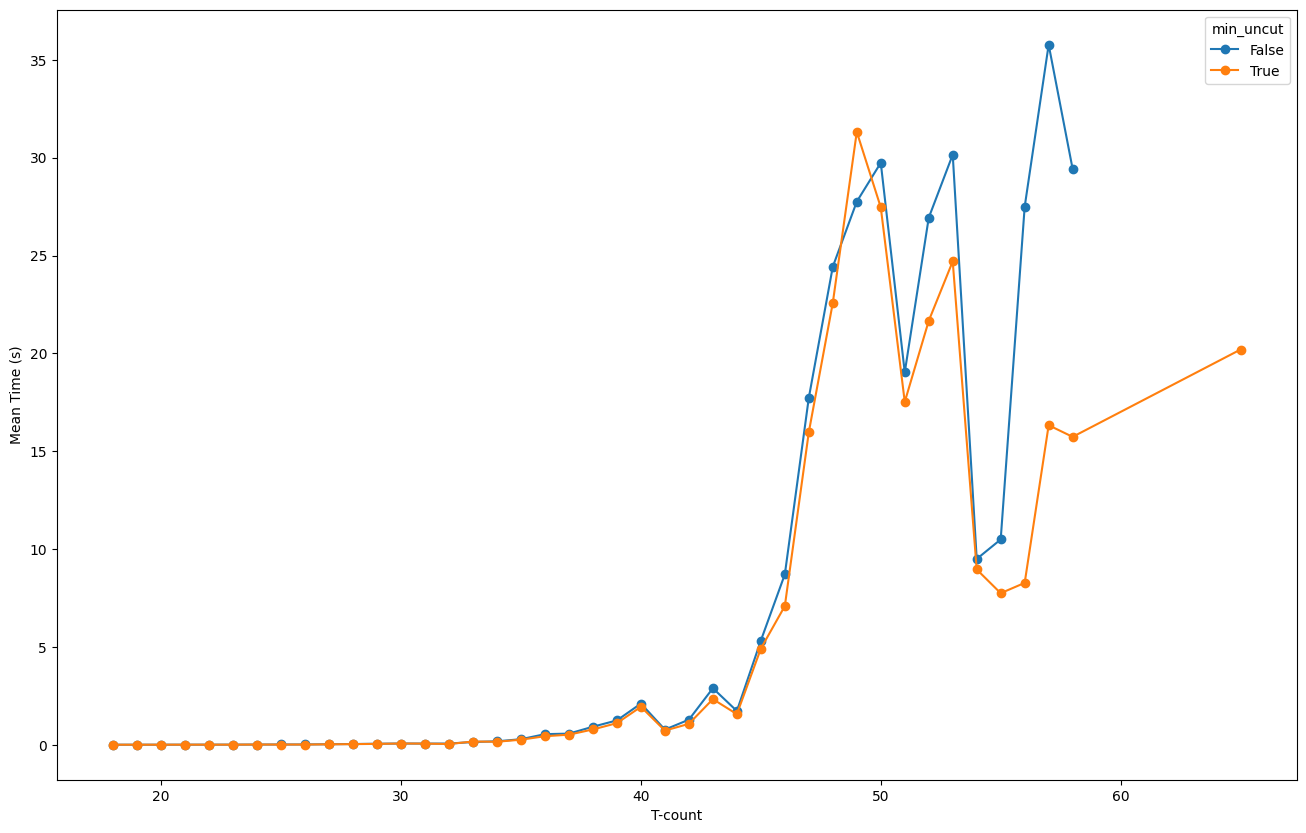

In [974]:
### Plot (No. of Gates vs. Average Simulation Time) ###
data.groupby([groupby_data,feat_name]).mean().unstack()["time"].plot(
    xlabel="T-count", 
    ylabel="Mean Time (s)",
    marker="o",
    figsize=(16,10)
)

<Axes: xlabel='T-count', ylabel='Mean alpha'>

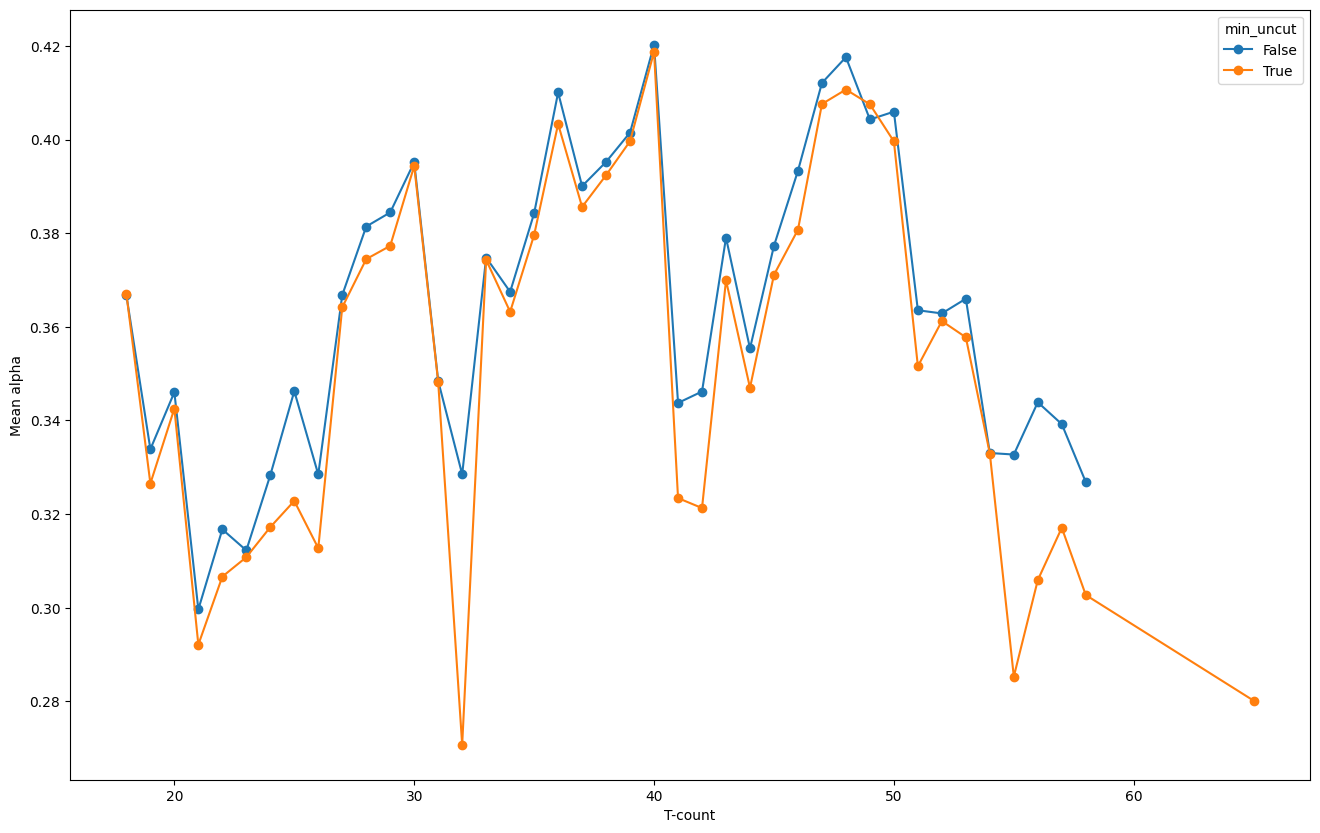

In [975]:
### Plot (No. of Gates vs. Average Simulation Time) ###
data.groupby([groupby_data,feat_name]).mean().unstack()["alpha"].plot(
    xlabel="T-count", 
    ylabel="Mean alpha",
    marker="o",
    figsize=(16,10)
)

<Axes: xlabel='T-count', ylabel='Median alpha'>

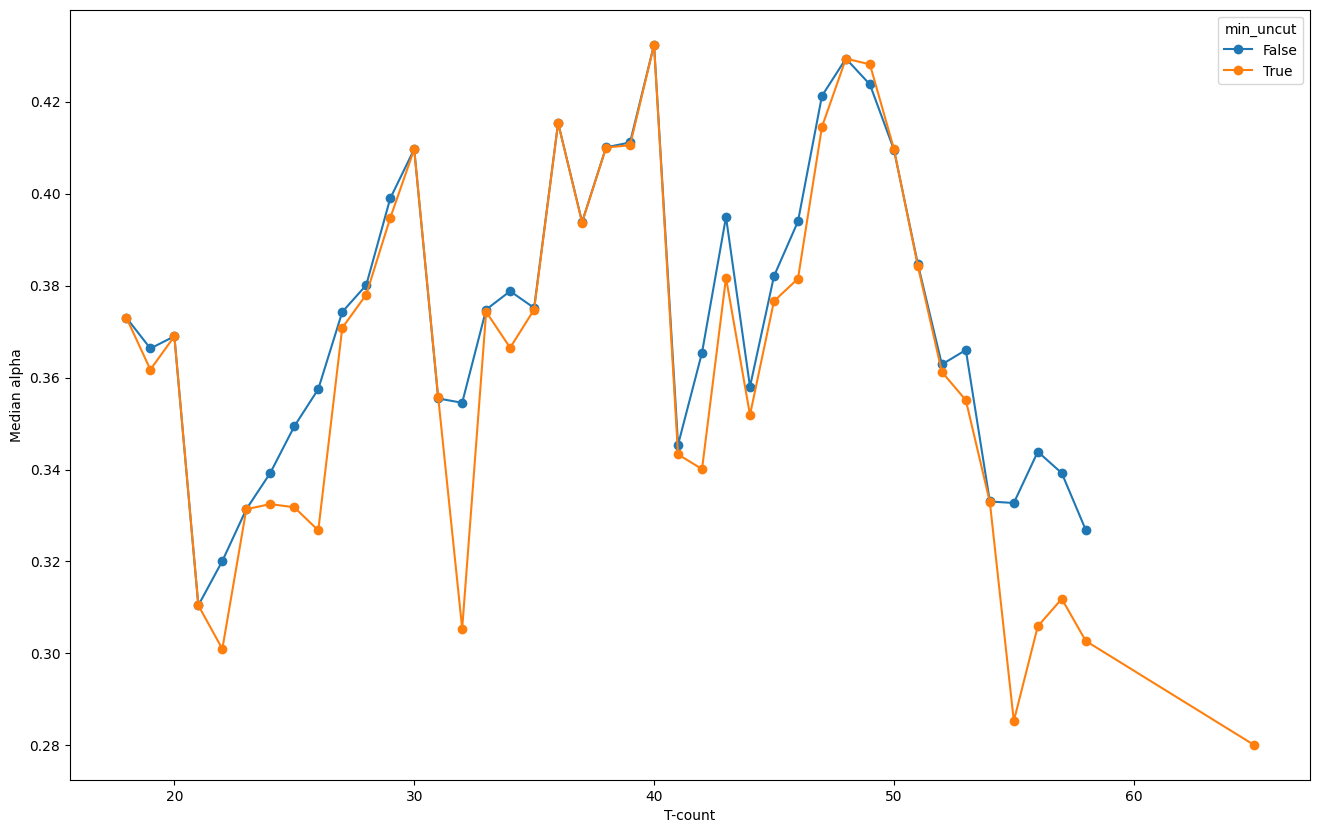

In [976]:
### Plot (No. of Gates vs. Average Simulation Time) ###
data.groupby([groupby_data,feat_name]).median().unstack()["alpha"].plot(
    xlabel="T-count", 
    ylabel="Median alpha",
    marker="o",
    figsize=(16,10)
)

<Axes: xlabel='T-count', ylabel='Mean Log terms'>

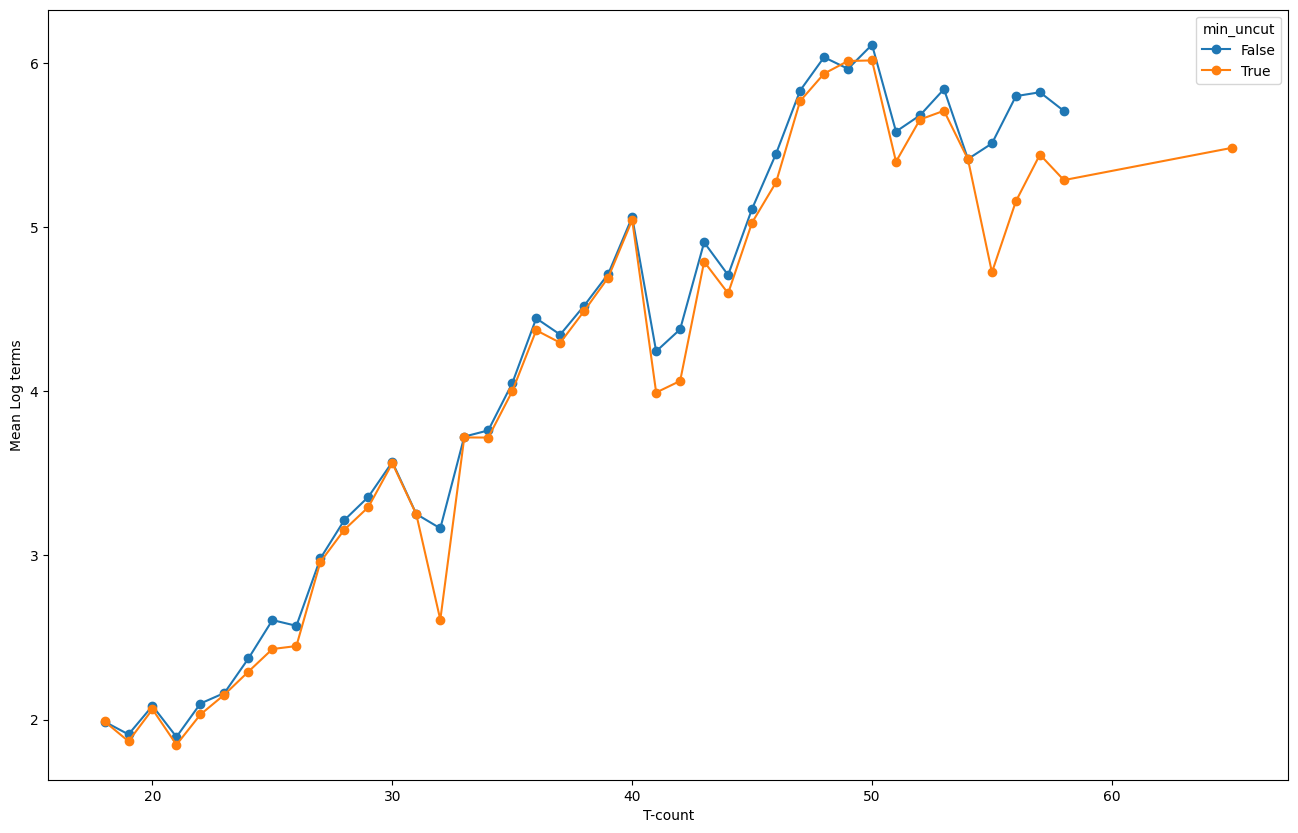

In [977]:
### Plot (No. of Gates vs. Average Simulation Time) ###
data.groupby([groupby_data,feat_name]).mean().unstack()["log_terms"].plot(
    xlabel="T-count", 
    ylabel="Mean Log terms",
    marker="o",
    figsize=(16,10)
)

<Axes: xlabel='T-count', ylabel='Median Log terms'>

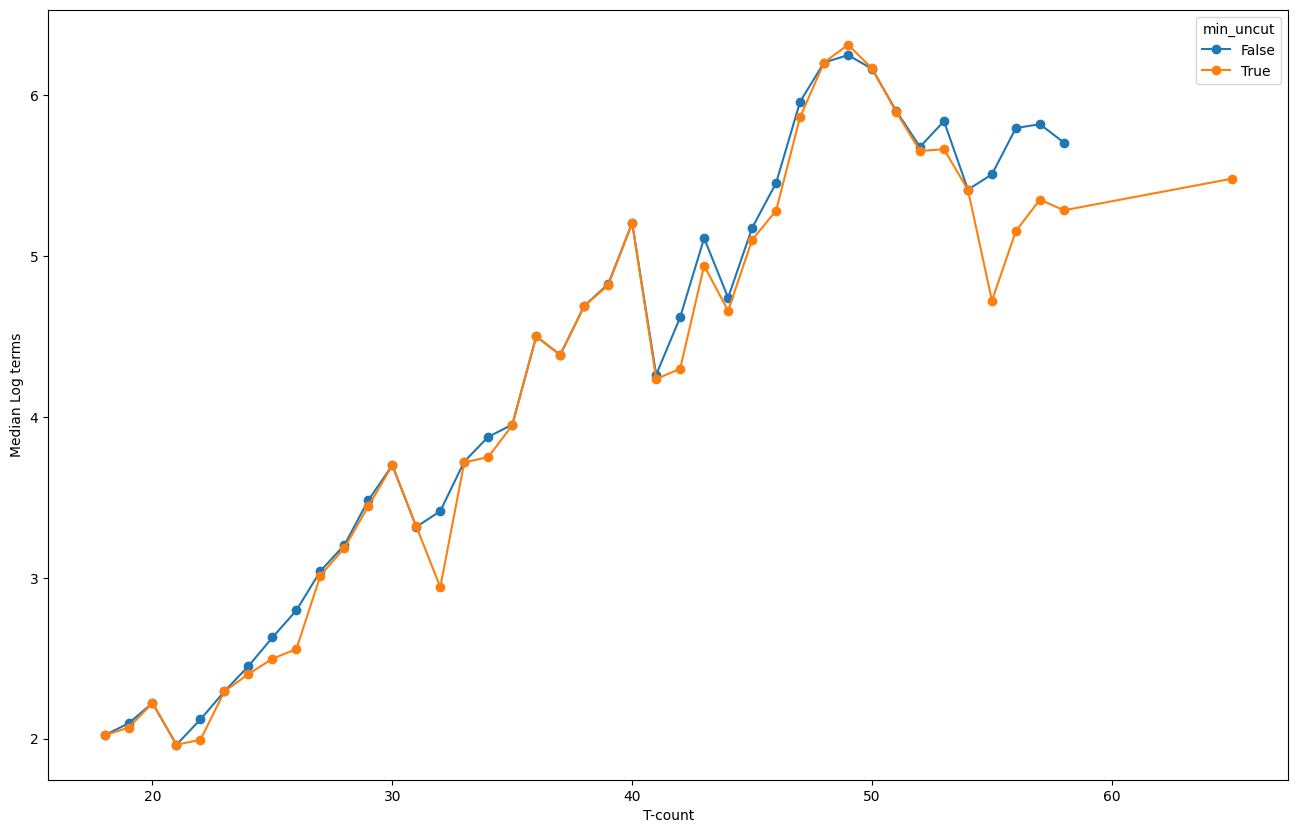

In [978]:
### Plot (No. of Gates vs. Average Simulation Time) ###
data.groupby([groupby_data,feat_name]).median().unstack()["log_terms"].plot(
    xlabel="T-count", 
    ylabel="Median Log terms",
    marker="o",
    figsize=(16,10)
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


      qs  depth  tcount  red_tcount  seed  terms   time     alpha min_uncut  \
2059   7     20      20          20   130    181  0.003  0.374992     False   
811    7     20      20          20   130    181  0.003  0.374992      True   
1846   7     20      20          20   271    122  0.003  0.346537     False   
606    7     20      20          20   271    121  0.003  0.345943      True   
1295   7     20      20          20   485    180  0.012  0.374593     False   

      log_terms  log_time  
2059   2.257679  0.477121  
811    2.257679  0.477121  
1846   2.086360  0.477121  
606    2.082785  0.477121  
1295   2.255273  1.079181  


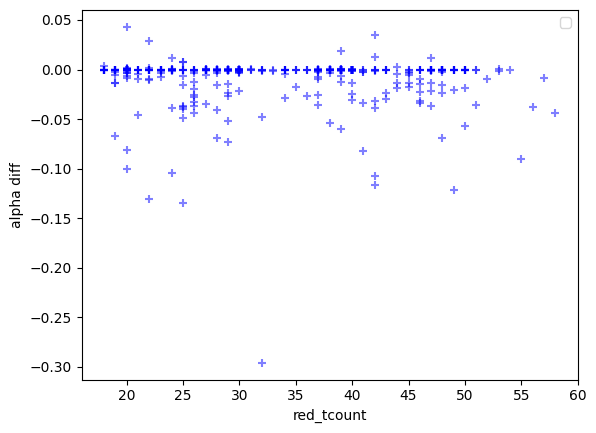

In [979]:
diff_df = data.copy()
diff_df.sort_values(["qs","depth","seed", feat_name], inplace=True)
is_paired = diff_df[["qs", "depth","seed"]].duplicated(keep=False)
single_df = diff_df[~is_paired]
diff_df = diff_df[is_paired]


# diff_df = diff_df.set_index(["qs","seed"])
# diff_df["alpha_diff"] = diff_df.groupby(["qs","seed"], as_index=False)["alpha"].apply(lambda x: x.diff(1))
print(diff_df.head())
# print(len(diff_df[ (diff_df["qs"] == 50)]))
diff_df["alpha_diff"] = diff_df.groupby(diff_df.min_uncut.eq(False).cumsum())["alpha"].diff()
# print(diff_df[ ["alpha_diff","alpha"]].head(100))
diff_df = diff_df.dropna()


# Plot the data with translucent points
plt.scatter(diff_df[groupby_data], diff_df['alpha_diff'], color='blue', alpha=0.5, marker='+')

# Set the x-axis label and y-axis label
plt.xlabel(groupby_data)
plt.ylabel('alpha diff')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [980]:
single_df.head(100)

,qs,depth,tcount,red_tcount,seed,terms,time,alpha,min_uncut,log_terms,log_time
1036,7,50,50,49,1308,2133361,36.966,0.429075,True,6.329064,4.567802
268,7,50,50,49,2592,2122460,37.544,0.428925,True,6.326840,4.574541
384,7,50,50,50,3497,2027750,36.420,0.419029,True,6.307014,4.561340
134,7,50,50,49,4321,2092732,36.549,0.428509,True,6.320714,4.562875
1119,7,50,50,49,9420,2095472,35.839,0.428548,True,6.321282,4.554356
38,19,50,50,49,596,2126362,39.537,0.428979,True,6.327637,4.597004
882,19,50,50,49,3923,2075883,38.788,0.428271,True,6.317203,4.588697
965,19,50,50,49,4916,2064780,36.574,0.428113,True,6.314874,4.563172
405,19,50,50,49,6421,1942211,32.999,0.426312,True,6.288296,4.518501
205,19,50,50,49,8351,1959135,35.627,0.426567,True,6.292064,4.551779


In [981]:
metric = "alpha_diff"
n1 = 5e-5
n2 = 1e-4

# Define an improvement as a positive value in metric
diff_df['%_improve'] = diff_df[metric] < 0
diff_df[f'%_improve_{n1}'] = diff_df[metric] < -n1
diff_df[f'%_improve_{n2}'] = diff_df[metric] < -n2
diff_df['%_deprove'] = diff_df[metric] > 0
diff_df[f'%_deprove_{n1}'] = diff_df[metric] > n1
diff_df[f'%_deprove_{n2}'] = diff_df[metric] > n2

# Group by 'max_tcount' and calculate the proportion of improvements
improvement_proportion = diff_df.groupby(groupby_data)['%_improve'].mean()
# Count the number of rows for each max_tcount value
count_df = diff_df[groupby_data].value_counts().reset_index(name='count').rename(columns={'index': groupby_data})
# Group by 'max_tcount' and calculate the proportion of improvements
improvement_proportion_5 = diff_df.groupby(groupby_data)[f'%_improve_{n1}'].mean()
improvement_proportion_1 = diff_df.groupby(groupby_data)[f'%_improve_{n2}'].mean()
# Count the number of rows for each max_tcount value
# count_df_5 = diff_df[groupby_data].value_counts().reset_index(name='count_5').rename(columns={'index': groupby_data})
# print(count_df_5.head())
# print(count_df.head())
deprovement_proportion = diff_df.groupby(groupby_data)['%_deprove'].mean()
deprovement_proportion_5 = diff_df.groupby(groupby_data)[f'%_deprove_{n1}'].mean()
deprovement_proportion_1 = diff_df.groupby(groupby_data)[f'%_deprove_{n2}'].mean()


prop_df = pd.merge(improvement_proportion, improvement_proportion_5, on=groupby_data)
prop_df = pd.merge(prop_df, improvement_proportion_1, on=groupby_data)

deprop_df = pd.merge(deprovement_proportion, deprovement_proportion_5, on=groupby_data)
deprop_df = pd.merge(deprop_df, deprovement_proportion_1, on=groupby_data)
# pcount_df = pd.merge(count_df, count_df_5, on=groupby_data)

# prop_df = pd.merge(prop_df, deprop_df, on=groupby_data)
prop_df = pd.merge(prop_df, count_df, on=groupby_data)
deprop_df = pd.merge(deprop_df, count_df, on=groupby_data)
print(prop_df.head(20))
print("overall proportion improve: ", diff_df["%_improve"].mean())
print("overall proportion deprove: ", diff_df["%_deprove"].mean())
print(f"overall proportion improve >{n1}: ", diff_df[f'%_improve_{n1}'].mean())
print(f"overall proportion deprove >{n1}: ", diff_df[f"%_deprove_{n1}"].mean())
print(f"overall proportion improve >{n2}: ", diff_df[f'%_improve_{n2}'].mean())
print(f"overall proportion deprove >{n2}: ", diff_df[f"%_deprove_{n2}"].mean())

    red_tcount  %_improve  %_improve_5e-05  %_improve_0.0001  count
0           18   0.111111         0.111111          0.111111      9
1           19   0.357143         0.357143          0.357143     14
2           20   0.304348         0.304348          0.304348     46
3           21   0.375000         0.375000          0.375000      8
4           22   0.333333         0.333333          0.333333     12
5           23   0.700000         0.700000          0.700000     10
6           24   0.583333         0.583333          0.500000     12
7           25   0.769231         0.769231          0.769231     13
8           26   0.923077         0.923077          0.923077     13
9           27   0.625000         0.625000          0.437500     16
10          28   0.842105         0.736842          0.631579     19
11          29   0.851852         0.740741          0.518519     27
12          30   0.700000         0.325000          0.225000     40
13          31   0.666667         0.666667      

In [982]:
print(prop_df[prop_df["%_improve"] > 0])

    red_tcount  %_improve  %_improve_5e-05  %_improve_0.0001  count
0           18   0.111111         0.111111          0.111111      9
1           19   0.357143         0.357143          0.357143     14
2           20   0.304348         0.304348          0.304348     46
3           21   0.375000         0.375000          0.375000      8
4           22   0.333333         0.333333          0.333333     12
5           23   0.700000         0.700000          0.700000     10
6           24   0.583333         0.583333          0.500000     12
7           25   0.769231         0.769231          0.769231     13
8           26   0.923077         0.923077          0.923077     13
9           27   0.625000         0.625000          0.437500     16
10          28   0.842105         0.736842          0.631579     19
11          29   0.851852         0.740741          0.518519     27
12          30   0.700000         0.325000          0.225000     40
13          31   0.666667         0.666667      

In [983]:
print(deprop_df[deprop_df["%_deprove"] > 0])

    red_tcount  %_deprove  %_deprove_5e-05  %_deprove_0.0001  count
0           18   0.111111         0.111111          0.111111      9
2           20   0.108696         0.108696          0.108696     46
4           22   0.166667         0.166667          0.166667     12
6           24   0.250000         0.250000          0.250000     12
7           25   0.153846         0.153846          0.153846     13
9           27   0.125000         0.125000          0.062500     16
10          28   0.105263         0.052632          0.052632     19
11          29   0.037037         0.037037          0.037037     27
12          30   0.150000         0.025000          0.000000     40
13          31   0.333333         0.333333          0.333333      3
19          37   0.052632         0.052632          0.000000     19
20          38   0.100000         0.050000          0.050000     20
21          39   0.090909         0.090909          0.030303     33
22          40   0.021277         0.000000      

In [984]:
### Best Improvement and Worst Loss ###
t_df = diff_df.copy()
# t_df = t_df[t_df["alpha_diff"].abs() > 1e-5]
t_df = t_df.groupby([groupby_data,"seed",feat_name]).mean().unstack()["alpha_diff"]
t_df.loc[:, "diff"] = -t_df[True]
t_df[["diff"]].groupby(groupby_data).agg(
    best_improvement=pd.NamedAgg("diff", "max"),
    worst_loss=pd.NamedAgg("diff", "min"),
    avg_diff=pd.NamedAgg("diff", "mean"),
    std_diff=pd.NamedAgg("diff", np.std),
)

/var/folders/jj/chbmjhbd5gbd4f05m1x14ld80000gn/T/ipykernel_3463/881357223.py:6: FutureWarning: The provided callable <function std at 0x10b20cfe0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  t_df[["diff"]].groupby(groupby_data).agg(


,best_improvement,worst_loss,avg_diff,std_diff
red_tcount,,,,
18,0.000876,-3.412000e-03,-0.000317,0.001288
19,0.067279,-0.000000e+00,0.007165,0.019339
20,0.040537,-2.229800e-02,0.001794,0.009674
21,0.045684,-0.000000e+00,0.007894,0.016816
22,0.130325,-2.883800e-02,0.011006,0.040844
23,0.007612,-0.000000e+00,0.001456,0.002453
24,0.046167,-9.360000e-04,0.008600,0.017908
25,0.135086,-7.876000e-03,0.025286,0.041696
26,0.043450,-0.000000e+00,0.015733,0.016042


<Axes: xlabel='Alpha Improvement', ylabel='T-count'>

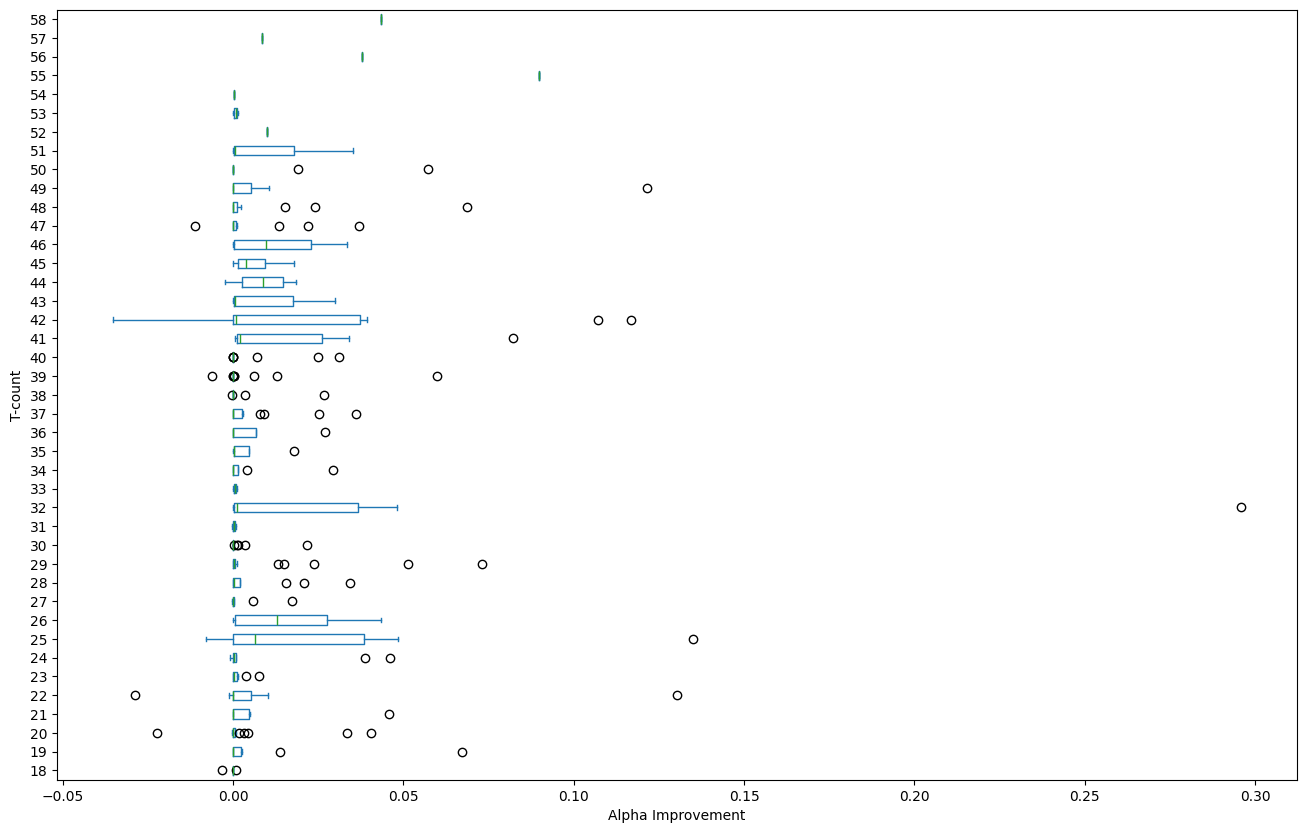

In [985]:
box_df = t_df.groupby(["seed", groupby_data]).mean().unstack()["diff"]
box_df.plot.box(
    xlabel="Alpha Improvement",
    ylabel="T-count",
    vert=False,
    figsize=(16,10),
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


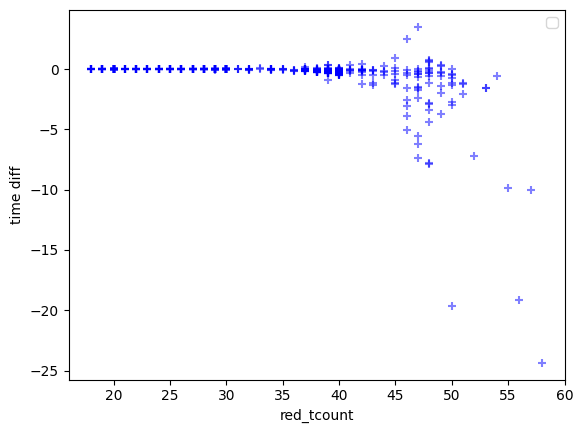

In [986]:
metric = "time"
diff_df = data.copy()
diff_df.sort_values(["qs","depth","seed", feat_name], inplace=True)
is_paired = diff_df[["qs", "depth","seed"]].duplicated(keep=False)
single_df = diff_df[~is_paired]
diff_df = diff_df[is_paired]


# diff_df = diff_df.set_index(["qs","seed"])
# diff_df["alpha_diff"] = diff_df.groupby(["qs","seed"], as_index=False)["alpha"].apply(lambda x: x.diff(1))

# print(len(diff_df[ (diff_df["qs"] == 50)]))
diff_df[f"{metric}_diff"] = diff_df.groupby(diff_df.min_uncut.eq(False).cumsum())[metric].diff()
# print(diff_df[ [f"{metric}_diff",metric]].head(100))
diff_df = diff_df.dropna()


# Plot the data with translucent points
plt.scatter(diff_df[groupby_data], diff_df[f'{metric}_diff'], color='blue', alpha=0.5, marker='+')

# Set the x-axis label and y-axis label
plt.xlabel(groupby_data)
plt.ylabel(f'{metric} diff')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [987]:
### Best Improvement and Worst Loss ###
t_df = diff_df.copy()
# t_df = t_df[t_df["alpha_diff"].abs() > 1e-5]
t_df = t_df.groupby([groupby_data,"seed",feat_name]).mean().unstack()[f"{metric}_diff"]
t_df.loc[:, "diff"] = -t_df[True]
t_df[["diff"]].groupby(groupby_data).agg(
    best_improvement=pd.NamedAgg("diff", "max"),
    worst_loss=pd.NamedAgg("diff", "min"),
    avg_diff=pd.NamedAgg("diff", "mean"),
    std_diff=pd.NamedAgg("diff", np.std),
)

/var/folders/jj/chbmjhbd5gbd4f05m1x14ld80000gn/T/ipykernel_3463/2363800623.py:6: FutureWarning: The provided callable <function std at 0x10b20cfe0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  t_df[["diff"]].groupby(groupby_data).agg(


,best_improvement,worst_loss,avg_diff,std_diff
red_tcount,,,,
18,0.0030,-0.0010,0.000937,0.001208
19,0.0010,-0.0000,0.000250,0.000399
20,0.0045,-0.0025,0.000467,0.001189
21,0.0010,-0.0090,-0.000786,0.003650
22,0.0050,-0.0010,0.001045,0.001588
23,0.0030,-0.0000,0.001100,0.001287
24,0.0040,-0.0060,-0.000150,0.002789
25,0.0100,-0.0050,0.002864,0.004382
26,0.0050,-0.0010,0.003000,0.002082


<Axes: xlabel='Time Improvement', ylabel='T-count'>

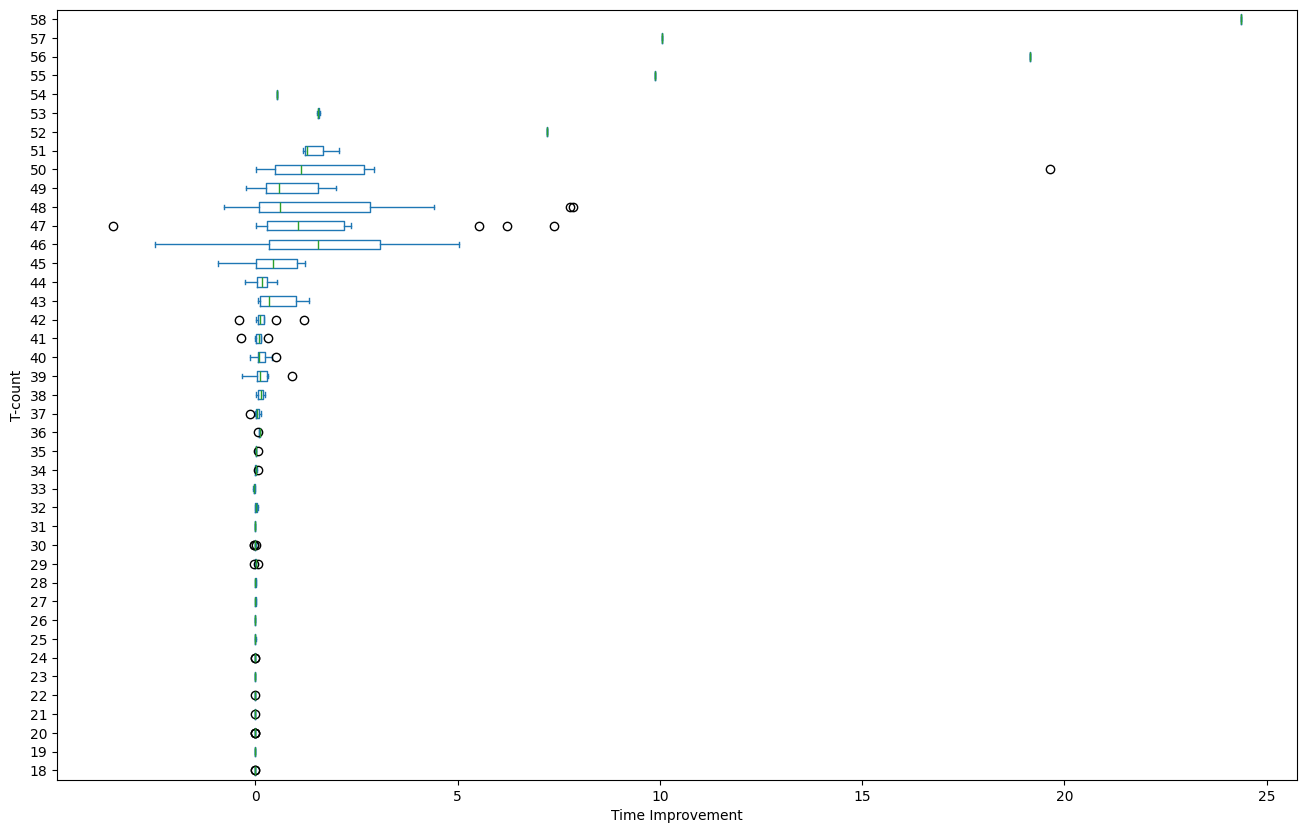

In [988]:
box_df = t_df.groupby(["seed", groupby_data]).mean().unstack()["diff"]
box_df.plot.box(
    xlabel="Time Improvement",
    ylabel="T-count",
    vert=False,
    figsize=(16,10),
)

In [989]:
# metric = "diff"
n1 = 1
n2 = 0.25


# Define an improvement as a positive value in metric
diff_df[f'%_improve_{metric}'] = diff_df[f'{metric}_diff'] < 0
diff_df[f'%_improve_{n1}_{metric}'] = diff_df[f'{metric}_diff'] < -n1
diff_df[f'%_improve_{n2}_{metric}'] = diff_df[f'{metric}_diff'] < -n2
diff_df[f'%_deprove_{metric}'] = diff_df[f'{metric}_diff'] > 0
diff_df[f'%_deprove_{n1}_{metric}'] = diff_df[f'{metric}_diff'] > n1
diff_df[f'%_deprove_{n2}_{metric}'] = diff_df[f'{metric}_diff'] > n2

# print(diff_df[diff_df['red_tcount'] > 40].head(100))

# Group by 'max_tcount' and calculate the proportion of improvements
improvement_proportion = diff_df.groupby(groupby_data)[f'%_improve_{metric}'].mean()
# Group by 'max_tcount' and calculate the proportion of improvements
improvement_proportion_5 = diff_df.groupby(groupby_data)[f'%_improve_{n1}_{metric}'].mean()
improvement_proportion_1 = diff_df.groupby(groupby_data)[f'%_improve_{n2}_{metric}'].mean()
# Count the number of rows for each max_tcount value
count_df = diff_df[groupby_data].value_counts().reset_index(name='count').rename(columns={'index': groupby_data})
# Count the number of rows for each max_tcount value
# count_df_5 = diff_df[groupby_data].value_counts().reset_index(name='count_5').rename(columns={'index': groupby_data})
# print(count_df_5.head())
# print(count_df.head())

# print(diff_df.groupby(groupby_data)['%_improve_1_time'].mean().head())
# print(improvement_proportion_5.head())


prop_df = pd.merge(improvement_proportion, improvement_proportion_5, on=groupby_data)
prop_df = pd.merge(prop_df, improvement_proportion_1, on=groupby_data)
# pcount_df = pd.merge(count_df, count_df_5, on=groupby_data)
prop_df = pd.merge(prop_df, count_df, on=groupby_data)
print(prop_df[prop_df[groupby_data] > 40].head(50))
print("overall proportion improve: ", diff_df[f"%_improve_{metric}"].mean())
print("overall proportion deprove: ", diff_df[f"%_deprove_{metric}"].mean())
print(f"overall proportion improve >{n1}: ", diff_df[f'%_improve_{n1}_{metric}'].mean())
print(f"overall proportion deprove >{n1}: ", diff_df[f"%_deprove_{n1}_{metric}"].mean())
print(f"overall proportion improve >{n2}: ", diff_df[f'%_improve_{n2}_{metric}'].mean())
print(f"overall proportion deprove >{n2}: ", diff_df[f"%_deprove_{n2}_{metric}"].mean())

    red_tcount  %_improve_time  %_improve_1_time  %_improve_0.25_time  count
23          41        0.666667          0.000000             0.166667      6
24          42        0.900000          0.100000             0.200000     10
25          43        1.000000          0.333333             0.500000      6
26          44        0.750000          0.000000             0.250000      4
27          45        0.714286          0.285714             0.571429      7
28          46        0.888889          0.555556             0.777778      9
29          47        0.928571          0.500000             0.785714     14
30          48        0.750000          0.437500             0.625000     16
31          49        0.750000          0.375000             0.750000      8
32          50        1.000000          0.555556             0.888889      9
33          51        1.000000          1.000000             1.000000      3
34          52        1.000000          1.000000             1.000000      1

In [990]:
print(prop_df[prop_df[f'%_improve_{metric}'] > 0])

    red_tcount  %_improve_time  %_improve_1_time  %_improve_0.25_time  count
0           18        0.666667          0.000000             0.000000      9
1           19        0.285714          0.000000             0.000000     14
2           20        0.304348          0.000000             0.000000     46
3           21        0.500000          0.000000             0.000000      8
4           22        0.583333          0.000000             0.000000     12
5           23        0.500000          0.000000             0.000000     10
6           24        0.416667          0.000000             0.000000     12
7           25        0.769231          0.000000             0.000000     13
8           26        0.846154          0.000000             0.000000     13
9           27        0.750000          0.000000             0.000000     16
10          28        0.842105          0.000000             0.000000     19
11          29        0.814815          0.000000             0.000000     27